In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torchvision
import open_clip
import re
from PIL import Image
import numpy as np
torch.manual_seed(1234)

def get_box_by_mask(mask):
    non_zero_indices = torch.nonzero(mask.float())
    min_indices = torch.min(non_zero_indices, dim=0).values
    max_indices = torch.max(non_zero_indices, dim=0).values
    top_left = min_indices
    bottom_right = max_indices + 1
    return top_left[1].item(), top_left[0].item(), bottom_right[1].item(), bottom_right[0].item()



def extract_box(text, w, h):
    pattern = r'\((.*?)\)'
    matches = re.findall(pattern, text)
    box = []
    for match in matches:
        box += match.split(',')
    for i in range(len(box)):
        box[i] = eval(box[i])
    box[0] = int(box[0] / 1000 * w)
    box[1] = int(box[1] / 1000 * h)
    box[2] = int(box[2] / 1000 * w)

    box[3] = int(box[3] / 1000 * h)
    return box

# Note: The default behavior now has injection attack prevention off.
tokenizer = AutoTokenizer.from_pretrained("ckpts/Qwen-VL", trust_remote_code=True)

# use cuda device
model = AutoModelForCausalLM.from_pretrained("ckpts/Qwen-VL",
                                             device_map="cuda:4",
                                             trust_remote_code=True,
                                             bf16=True).eval()

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
from segment_anything import sam_model_registry, SamPredictor
import torchvision
import open_clip
sam_checkpoint = "ckpts/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:3"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

#clip
preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711],
            ),
        ]
    )
clip_model, _, _ = open_clip.create_model_and_transforms("ViT-B-16",
                                                        pretrained="laion2b_s34b_b88k",
                                                        precision="fp16",
                                                        device='cuda:3')

NameError: name 'torchvision' is not defined

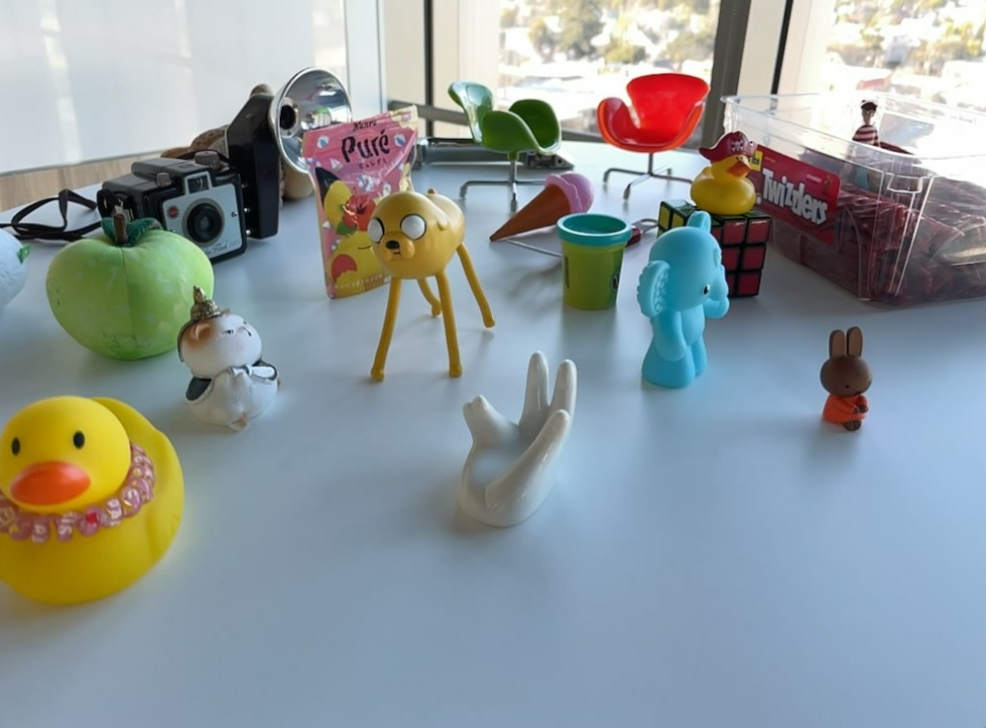

In [20]:
prompt = "what is suitable for people to sit down and is green"
image_path = 'data/gsgrouping/figurines/images/frame_00004.jpg'
Image.open(image_path)

In [11]:

query = tokenizer.from_list_format([
    {'image': image_path},
    {'text': qwen_template0(prompt)},
])

# inputs = tokenizer(query, return_tensors='pt')
# inputs = inputs.to(model.device)
# pred = model.generate(**inputs)
# response = tokenizer.decode(pred.cpu()[0], skip_special_tokens=False)

response, history = model.chat(tokenizer, query=query, history=None)
print(response)

AssertionError: We detect you are probably using the pretrained model (rather than chat model) for chatting, since the chat_format in generation_config is not "chatml".
If you are directly using the model downloaded from Huggingface, please make sure you are using our "Qwen/Qwen-7B-Chat" Huggingface model (rather than "Qwen/Qwen-7B") when you call model.chat().
我们检测到您可能在使用预训练模型（而非chat模型）进行多轮chat，因为您当前在generation_config指定的chat_format，并未设置为我们在对话中所支持的"chatml"格式。
如果您在直接使用我们从Huggingface提供的模型，请确保您在调用model.chat()时，使用的是"Qwen/Qwen-7B-Chat"模型（而非"Qwen/Qwen-7B"预训练模型）。


In [21]:

query = tokenizer.from_list_format([
    {'image': image_path},
    {'text': qwen_template1(prompt)},
])

inputs = tokenizer(query, return_tensors='pt')
inputs = inputs.to(model.device)
pred = model.generate(**inputs)
response = tokenizer.decode(pred.cpu()[0], skip_special_tokens=False)

# response, history = model.chat(tokenizer, query=query, history=None)
print(response)
# 图中是一名年轻女子在沙滩上和她的狗玩耍，狗的品种可能是拉布拉多。她们坐在沙滩上，狗的前腿抬起来，似乎在和人类击掌。两人之间充满了信任和爱。

# 2nd dialogue turn
# response, history = model.chat(tokenizer, '输出"击掌"的检测框', history=history)
# print(response)

# print(response)
# <img>https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg</img>Generate the caption in English with grounding:<ref> Woman</ref><box>(451,379),(731,806)</box> and<ref> her dog</ref><box>(219,424),(576,896)</box> playing on the beach<|endoftext|>
image = tokenizer.draw_bbox_on_latest_picture(response)
if image:
  image.save('result_qwen.jpg')
else:
  print("no box")


image_pil = Image.open(image_path)
image_np = np.array(image_pil)
box = extract_box(response, image_pil.width, image_pil.height)

predictor.set_image(image_np)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=np.array(box)[None, :],
    multimask_output=False,
)
mask = torch.from_numpy(masks[0])
bounding_box_image_np = image_np[box[1]: box[3], box[0]: box[2], :]
image_mask_np = image_np.copy()
image_mask_np[~mask, :] = np.array([0, 0, 0])
mask_bounding_box = get_box_by_mask(mask)
bounding_box_image_mask_np = image_mask_np[mask_bounding_box[1]:mask_bounding_box[3], mask_bounding_box[0]:mask_bounding_box[2], :]
bouning_box_image_pil = Image.fromarray(bounding_box_image_np)
bounding_box_image_mask_pil = Image.fromarray(bounding_box_image_mask_np)
bouning_box_image_pil.save(f'result_reasoning_box.png')
bounding_box_image_mask_pil.save(f'result_reasoning_mask.png')
bounding_box_image_mask_tensor = preprocess(bounding_box_image_mask_pil).half().to(device)[None]
bounding_box_image_mask_clip_embedding = clip_model.encode_image(bounding_box_image_mask_tensor)
bounding_box_image_mask_clip_embedding_norm = bounding_box_image_mask_clip_embedding / bounding_box_image_mask_clip_embedding.norm(dim=-1, keepdim=True)

Picture 1: <img>data/gsgrouping/figurines/images/frame_00004.jpg</img>
Output the bounding box of the object that best matches the text description, not the bounding box of an irrelevant object. Please grounding <ref> what is suitable for people to sit down and is green </ref><box>(42,286),(243,507)</box>.<|endoftext|>


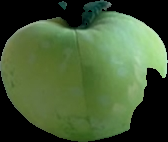

In [22]:
bounding_box_image_mask_pil

In [7]:
from PIL import Image, ImageDraw
image = Image.open("data/gsgrouping/figurines/images/frame_00004.jpg")
image = image.resize((image.width // 4, image.height // 4))
response = [0.075, 0.391, 0.269, 0.664]
max_edge = max((image.width, image.height))
img_box = image.copy()
draw = ImageDraw.Draw(img_box)
# if image.width < image.height:
#     x_origin =(image.height - image.width)// 2
#     y_origin =0
# else:
#     x_origin =0
#     y_origin =(image.width - image.height)// 2
x1, y1, x2, y2 = response
x1 = x1 * image.width
y1 = y1 * image.height
x2 = x2 * image.width
y2 = y2 * image.height
draw.rectangle((x1 ,y1, x2, y2),outline='red', width=2)

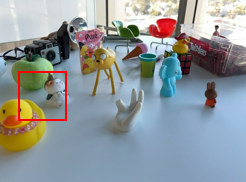

In [8]:
img_box

In [1]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('ckpts/MiniCPM-Llama3-V-2_5', trust_remote_code=True, torch_dtype=torch.float16, device_map='cuda:4')
# model = model.to(device='cuda')

tokenizer = AutoTokenizer.from_pretrained('ckpts/MiniCPM-Llama3-V-2_5', trust_remote_code=True)
model.eval()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MiniCPMV(
  (llm): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 4096)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm()
          (post_attention_layernorm): LlamaRMSNorm()
   

In [6]:
# test.py


image = Image.open("data/gsgrouping/figurines/images/frame_00004.jpg").convert('RGB')
question = 'Please print the coordinates of the object that best matches the following text description in the format [x1, y1, x2, y2]. Text description: green apple.'
msgs = [{'role': 'user', 'content': question}]

res = model.chat(
    image=image,
    msgs=msgs,
    tokenizer=tokenizer,
    sampling=False, # if sampling=False, beam_search will be used by default
    temperature=1.0,
    # system_prompt='' # pass system_prompt if needed
)
print(res)

## if you want to use streaming, please make sure sampling=True and stream=True
## the model.chat will return a generator


# generated_text = ""
# for new_text in res:
#     generated_text += new_text
#     print(new_text, flush=True, end='')


[75 391 269 664</box>
[75 391 269 664</box>

In [1]:
import re
from dashscope import MultiModalConversation
from http import HTTPStatus
from PIL import Image
from PIL import ImageDraw
from copy import deepcopy
import dashscope
def qwen_template0(prompt):
    return f"Please determine whether there is an object corresponding to the following text description in the scene. If there is, output 'yes', otherwise output 'no'. The text description : {prompt}."

def qwen_template1(prompt):
    return f'Please grounding <ref> {prompt} </ref>'

def qwen_template2(prompt):
    return f'Please output the name of the object that best matches the following text description. The text description : {prompt}.'
    
def extract_box(text, w, h):
    pattern = r'\((.*?)\)'
    matches = re.findall(pattern, text)
    box = []
    for match in matches:
        box += match.split(',')
    for i in range(len(box)):
        box[i] = eval(box[i])
    box[0] = int(box[0] / 1000 * w)
    box[1] = int(box[1] / 1000 * h)
    box[2] = int(box[2] / 1000 * w)
    box[3] = int(box[3] / 1000 * h)
    return box
def reasoning_grouding_by_qwen(file_path, text_prompt):
    """Sample of use local file.
       linux&mac file schema: file:///home/images/test.png
       windows file schema: file://D:/images/abc.png
    """

    messages = [{
        'role': 'system',
        'content': [{
            'text': '''
                    You are an AI assistant that is good at locating objects that best match the text description
                    '''
        }]
    }, {
        'role':
        'user',
        'content': [
            {
                'image': f'file://{file_path}'
            },
            {
                'text': text_prompt
            },
        ]
    }]
    response = MultiModalConversation.call(model='qwen-vl-plus', messages=messages)
    image = Image.open(file_path)
    
    # print(response.output.choices)
    # answer = response.output.choices[0].message.content[0]['box']
    answer = response.output.choices[0].message.content[0]['box']
    print(answer)
    # result_image = response.output.choices[0].message.content[1]['result_image']
    # result_image = Image.open(requests.get(result_image, stream=True).raw)
    box = extract_box(answer, *(image.size))
    return answer, box, image

def reasoning_by_qwen(file_path, text_prompt):
    """Sample of use local file.
       linux&mac file schema: file:///home/images/test.png
       windows file schema: file://D:/images/abc.png
    """

    messages = [{
        
        'role': 'system',
        'content': [{
            'text': '''
                   You are an AI assistant that is good at determining whether there is an object in the scene that best matches the description of the text, returning yes if you can observe it, and no otherwise.
                    '''
        }]
    }, {
        'role':
        'user',
        'content': [
            {
                'image': f'file://{file_path}'
            },
            {
                'text': text_prompt
            },
        ]
    }]
    response = MultiModalConversation.call(model='qwen-vl-plus', messages=messages)
    image = Image.open(file_path)
    
    # print(response.output.choices)
    answer = response.output.choices[0].message.content[0]['text']
    print(answer)
    # result_image = response.output.choices[0].message.content[1]['result_image']
    # result_image = Image.open(requests.get(result_image, stream=True).raw)
    
    return answer

def draw_rectangle(image, rectangle_coordinates, outline_color="red", thickness=2):
    # 打开图像
    image = deepcopy(image)
    # 创建绘图对象
    draw = ImageDraw.Draw(image)
    for rectangle_coordinate in rectangle_coordinates:
        draw.rectangle(rectangle_coordinate, outline=outline_color, width=thickness)

    return image

In [2]:
from segment_anything import sam_model_registry, SamPredictor
import torchvision
import open_clip
sam_checkpoint = "ckpts/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:3"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

#clip
preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711],
            ),
        ]
    )
clip_model, _, _ = open_clip.create_model_and_transforms("ViT-B-16",
                                                        pretrained="laion2b_s34b_b88k",
                                                        precision="fp16",
                                                        device='cuda:3')

In [15]:
file_path = "data/ovs3d/sofa/images_4/03.jpg"
prompt = "which is red and looks like a controller"


In [16]:
answer = reasoning_by_qwen(file_path, qwen_template2(prompt))

Pink Nintendo Switch Joy-Con controllers


In [17]:
answer, box, image = reasoning_grouding_by_qwen(file_path, qwen_template1(prompt))

<ref>which is red and looks like a controller</ref><box>(398,547),(492,716)</box>


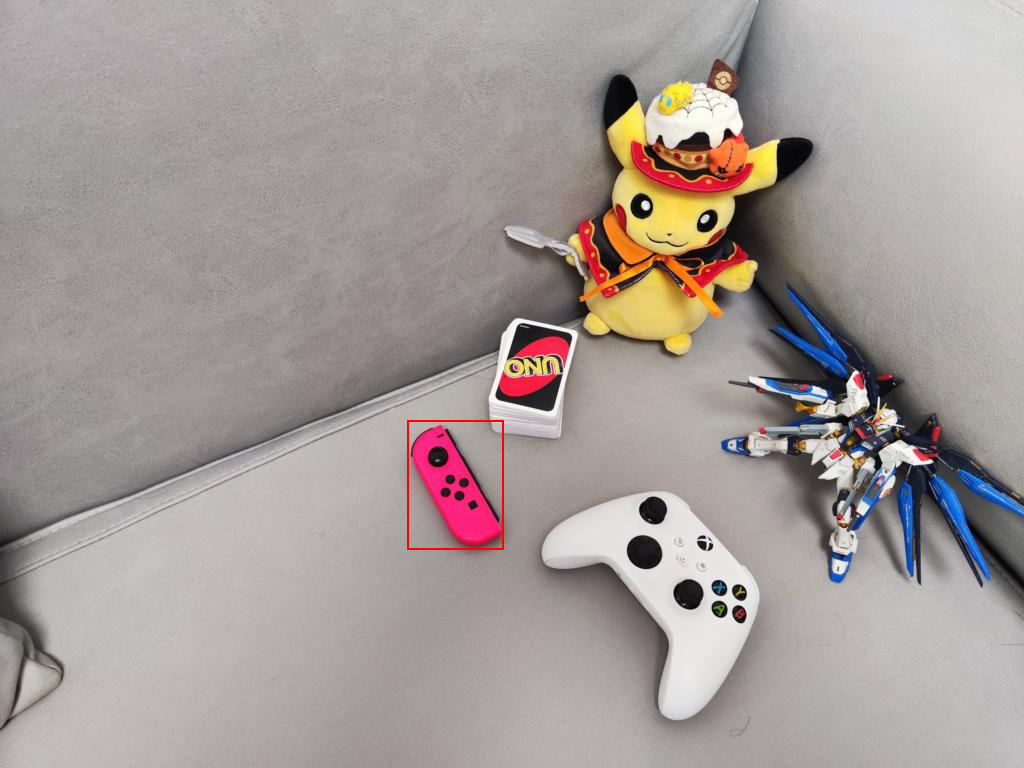

In [18]:
reasoning_result = draw_rectangle(image, [box])
reasoning_result

In [160]:
import numpy as np
import torch
def get_box_by_mask(mask):
    non_zero_indices = torch.nonzero(mask.float())
    min_indices = torch.min(non_zero_indices, dim=0).values
    max_indices = torch.max(non_zero_indices, dim=0).values
    top_left = min_indices
    bottom_right = max_indices + 1
    return top_left[1].item(), top_left[0].item(), bottom_right[1].item(), bottom_right[0].item()
image_np = np.array(image)

predictor.set_image(image_np)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=np.array(box)[None, :],
    multimask_output=False,
)
mask = torch.from_numpy(masks[0])
bounding_box_image_np = image_np[box[1]: box[3], box[0]: box[2], :]
image_mask_np = image_np.copy()
image_mask_np[~mask, :] = np.array([0, 0, 0])
mask_bounding_box = get_box_by_mask(mask)
bounding_box_image_mask_np = image_mask_np[mask_bounding_box[1]:mask_bounding_box[3], mask_bounding_box[0]:mask_bounding_box[2], :]
bouning_box_image_pil = Image.fromarray(bounding_box_image_np)
bounding_box_image_mask_pil = Image.fromarray(bounding_box_image_mask_np)
bouning_box_image_pil.save(f'result_reasoning_box.png')
bounding_box_image_mask_pil.save(f'result_reasoning_mask.png')
bounding_box_image_mask_tensor = preprocess(bounding_box_image_mask_pil).half().to(device)[None]
bounding_box_image_mask_clip_embedding = clip_model.encode_image(bounding_box_image_mask_tensor)
bounding_box_image_mask_clip_embedding_norm = bounding_box_image_mask_clip_embedding / bounding_box_image_mask_clip_embedding.norm(dim=-1, keepdim=True)

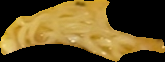

In [161]:
bounding_box_image_mask_pil

In [11]:
import torch

cache = torch.load('output/16_ovs3d_masks/room/01/what is made of red wood/cache.pt')

In [12]:
cache.keys()

dict_keys(['category', 'box', 'category_embeddings', 'mask_clip_embeddings', 'similarity_score', 'seleced_instance_index'])

In [13]:
cache['category']

'basket'

In [14]:
cache['similarity_score']

tensor([[0.5112, 0.4863]], device='cuda:0', dtype=torch.float16)